# A7: Covid Cases and their Impact on Domestic Violence in Atlanta, GA.
## Data 512
## Author: Grant Savage

A7 is the product of several assignment and relies on the analysis conducted in A4 for Cobb County, GA. The begining of this notebook is the work I did for the A4 assignment and I extend the analysis with additional data for my A7 assignment.



# A4

## The question to answer is:
## How did masking policies change the progression of confirmed COVID-19 cases from February 1, 2020 through October 15, 2021?
### Note - Cobb County, GA does not have a masking policy so for this assignment I have just looked at the progression of confirmed COVID-19 cases from February 1, 2020 through Octover 15, 2021. To do this I created two plots; the first shows the rate of infection over time in Cobb County, and the second shows the change in the rate of infection over time in Cobb County.

# Import Libraries and define UI settings for whole notebook

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import datetime
from IPython.core.interactiveshell import InteractiveShell
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import PoissonRegressor
from sklearn.linear_model import Ridge
from bokeh.plotting import figure, show
import matplotlib.dates as mdates
from statistics import mean


import ruptures as rpt

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import plotly.graph_objs as go

import warnings

In [2]:
# inline graphs
%matplotlib inline
# multiple outputs from a single cell
InteractiveShell.ast_node_interactivity = "all"
# increase max columns displayed by pandas
pd.set_option("display.max_columns", 50)
#supress python warnings from UI
warnings.filterwarnings('ignore')

# Get Data for A4
[U.S. State and Territorial Public Mask Mandates From April 10, 2020 through August 15, 2021 by County by Day](https://data.cdc.gov/Policy-Surveillance/U-S-State-and-Territorial-Public-Mask-Mandates-Fro/62d6-pm5i) data comes from CDC.

[RAW_us_confirmed_cases](https://www.kaggle.com/antgoldbloom/covid19-data-from-john-hopkins-university/version/374?select=RAW_us_confirmed_cases.csv) comes from Kaggle.

[Mask use by county](https://github.com/nytimes/covid-19-data/tree/master/mask-use) data is provided by the New York Times.

In [3]:
mask_mandate = pd.read_csv('U.S._State_and_Territorial_Public_Mask_Mandates_From_April_10__2020_through_August_15__2021_by_County_by_Day.csv')
confirmed_cases = pd.read_csv('RAW_us_confirmed_cases.csv')
mask_use = pd.read_csv('mask-use-by-county.csv')

In [4]:
#From 2020 US census Population of Cobb county GA
population = 766149

In [5]:
print('Mask Mandate:')
mask_mandate.head()
mask_mandate.dtypes
print('Confirmed Cases:')
confirmed_cases.head()
confirmed_cases.dtypes
print('Mask Use:')
mask_use.head()
mask_use.dtypes

Mask Mandate:


,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation
0,AL,Autauga County,1,1,4/10/2020,2,NaN,NaN,NaN,NaN
1,AL,Autauga County,1,1,4/11/2020,2,NaN,NaN,NaN,NaN
2,AL,Autauga County,1,1,4/12/2020,2,NaN,NaN,NaN,NaN
3,AL,Autauga County,1,1,4/13/2020,2,NaN,NaN,NaN,NaN
4,AL,Autauga County,1,1,4/14/2020,2,NaN,NaN,NaN,NaN


State_Tribe_Territory            object
County_Name                      object
FIPS_State                        int64
FIPS_County                       int64
date                             object
order_code                        int64
Face_Masks_Required_in_Public    object
Source_of_Action                 object
URL                              object
Citation                         object
dtype: object

Confirmed Cases:


,Province_State,Admin2,UID,iso2,iso3,code3,FIPS,Country_Region,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,...,10/3/21,10/4/21,10/5/21,10/6/21,10/7/21,10/8/21,10/9/21,10/10/21,10/11/21,10/12/21,10/13/21,10/14/21,10/15/21,10/16/21,10/17/21,10/18/21,10/19/21,10/20/21,10/21/21,10/22/21,10/23/21,10/24/21,10/25/21,10/26/21,10/27/21
0,Alabama,Autauga,84001001,US,USA,840,1001.0,US,32.539527,-86.644082,"Autauga, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,9780,9790,9799,9810,9826,9839,9843,9850,9851,9858,9865,9874,9883,9893,9901,9904,9909,9910,9954,9967,10043,10047,10048,10061,10083
1,Alabama,Baldwin,84001003,US,USA,840,1003.0,US,30.727750,-87.722071,"Baldwin, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,36579,36602,36697,36734,36780,36814,36870,36889,36905,36933,36965,37018,37044,37069,37087,37098,37127,37167,37192,37224,37245,37258,37266,37285,37325
2,Alabama,Barbour,84001005,US,USA,840,1005.0,US,31.868263,-85.387129,"Barbour, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3519,3521,3524,3527,3536,3541,3545,3546,3546,3548,3550,3552,3553,3554,3556,3560,3563,3565,3566,3575,3577,3578,3578,3583,3595
3,Alabama,Bibb,84001007,US,USA,840,1007.0,US,32.996421,-87.125115,"Bibb, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4157,4163,4167,4168,4176,4184,4192,4193,4194,4202,4208,4211,4216,4216,4217,4217,4232,4236,4240,4246,4251,4252,4253,4256,4262
4,Alabama,Blount,84001009,US,USA,840,1009.0,US,33.982109,-86.567906,"Blount, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,9870,9878,9923,9941,9957,9970,9998,10013,10020,10037,10047,10071,10081,10094,10102,10104,10113,10132,10162,10179,10192,10197,10207,10227,10338


Province_State    object
Admin2            object
UID                int64
iso2              object
iso3              object
                   ...  
10/23/21           int64
10/24/21           int64
10/25/21           int64
10/26/21           int64
10/27/21           int64
Length: 656, dtype: object

Mask Use:


,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,1001,0.053,0.074,0.134,0.295,0.444
1,1003,0.083,0.059,0.098,0.323,0.436
2,1005,0.067,0.121,0.120,0.201,0.491
3,1007,0.020,0.034,0.096,0.278,0.572
4,1009,0.053,0.114,0.180,0.194,0.459


COUNTYFP        int64
NEVER         float64
RARELY        float64
SOMETIMES     float64
FREQUENTLY    float64
ALWAYS        float64
dtype: object

### Defining my county data

In [6]:
cobb_county = pd.DataFrame.from_dict({'Order':[53],
                           'Rank':[85],
                           'County':['Cobb'],
                           'State':['Georgia'],
                           'Area_km^2':[879.43],
                           'Area_mi^2':[39.55],
                           'Population_2020_Census':[766149],
                           'Population_Increase_from_2010':[78071],
                           'County_Seat':['Marietta']})

# Clean A4 data

## Limit the collected data to just Cobb county Georgia.

In [7]:
# mask mandate data
mm_cobb = mask_mandate[mask_mandate.County_Name.isin(['Cobb County'])]

# mask use data
mu_cobb = mask_use[mask_use.COUNTYFP==13067]

# confirmed cases data
cc_cobb = confirmed_cases[(confirmed_cases.Province_State=='Georgia') & (confirmed_cases.Admin2 =='Cobb')]

## Remove unnecessary columns from confirmed cases data

In [8]:
cc_column_list = list(cc_cobb.columns)
remove_list = ['Province_State', 'Admin2', 'UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Country_Region','Lat',
 'Long_',
 'Combined_Key']

In [9]:
for l in remove_list:
    cc_column_list.remove(l)

## Transpose confirmed cases data and set datetime field

In [10]:
mcc_cobb = cc_cobb.melt(value_vars=cc_column_list, var_name='date', value_name='confirmed_cases')
mcc_cobb.date = pd.to_datetime(mcc_cobb.date)

## Calulculate the important features:
### moving average of cases, rate of infection,  and the at risk population, delta of the infection rate, and total infected

In [11]:
# calculate moving average using a 7 day window to adjust for weekly seasonality of reported cases.
mcc_cobb['ma'] = mcc_cobb.confirmed_cases.rolling(window=7).mean().round()
# calculate the smoothed rate of confirmed cases
mcc_cobb['ma_delta']= mcc_cobb['ma'].diff()
# determine at risk population
mcc_cobb['at_risk_pop'] = population - mcc_cobb.confirmed_cases

# calculate infection rate and the change in infection rate.
# assumption, every infection lasts a 14 day period of time. Once infected a person cannot get infected again.
mcc_cobb['infection_rate'] = (mcc_cobb['ma_delta'].rolling(min_periods=1, window=14).sum()/mcc_cobb.at_risk_pop)
mcc_cobb['Infection Rate Delta']= mcc_cobb['infection_rate'].diff()

#calculate total number of currently infected people
mcc_cobb['infected'] = 100*(mcc_cobb['ma_delta'].rolling(min_periods=1, window=14).sum())

In [12]:
mcc_cobb.tail()

,date,confirmed_cases,ma,ma_delta,at_risk_pop,infection_rate,Infection Rate Delta,infected
640,2021-10-23,108543,108308.0,95.0,657606,0.002939,-0.000199,193300.0
641,2021-10-24,108543,108404.0,96.0,657606,0.002740,-0.000199,180200.0
642,2021-10-25,108763,108491.0,87.0,657386,0.002616,-0.000124,172000.0
643,2021-10-26,108843,108576.0,85.0,657306,0.002417,-0.000199,158900.0
644,2021-10-27,109032,108673.0,97.0,657117,0.002225,-0.000193,146200.0


### Set index as date for graphing

In [13]:
mcc_cobb.set_index('date', inplace=True)

# Plot the Change in Rate of Infection for Cobb County GA

Text(0.5, 1.0, 'Change in the Rate of Infection for Cobb County GA (No mask policies in effect)')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Change in the Rate of Infection')

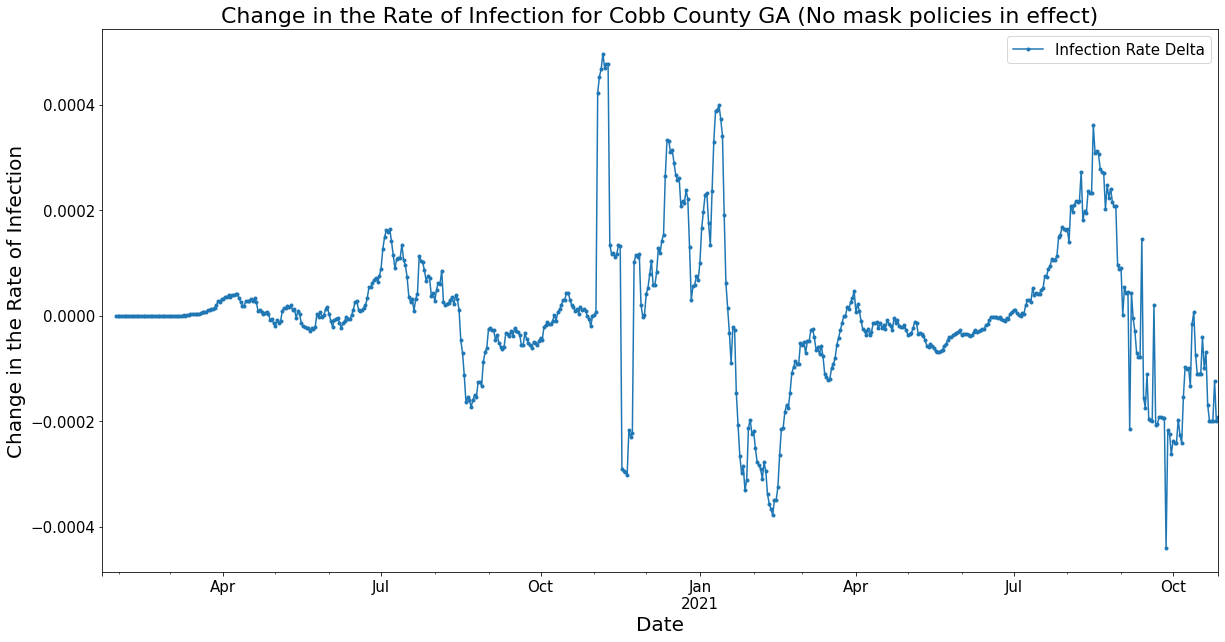

In [14]:
ax =mcc_cobb['Infection Rate Delta'].plot(marker='.', legend =True, figsize =(20,10), fontsize=15, x_compat=False)
ax.set_title('Change in the Rate of Infection for Cobb County GA (No mask policies in effect)',fontdict={'fontsize':22})
ax.set_xlabel('Date', fontsize=20)
ax.set_ylabel('Change in the Rate of Infection', fontsize=20)
ax.legend(loc=1,fontsize=15)


# Plot the Rate of Infection for Cobb County GA

Text(0.5, 1.0, 'Rate of Infection for Cobb County GA (No mask policies in effect)')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Rate of Infection')

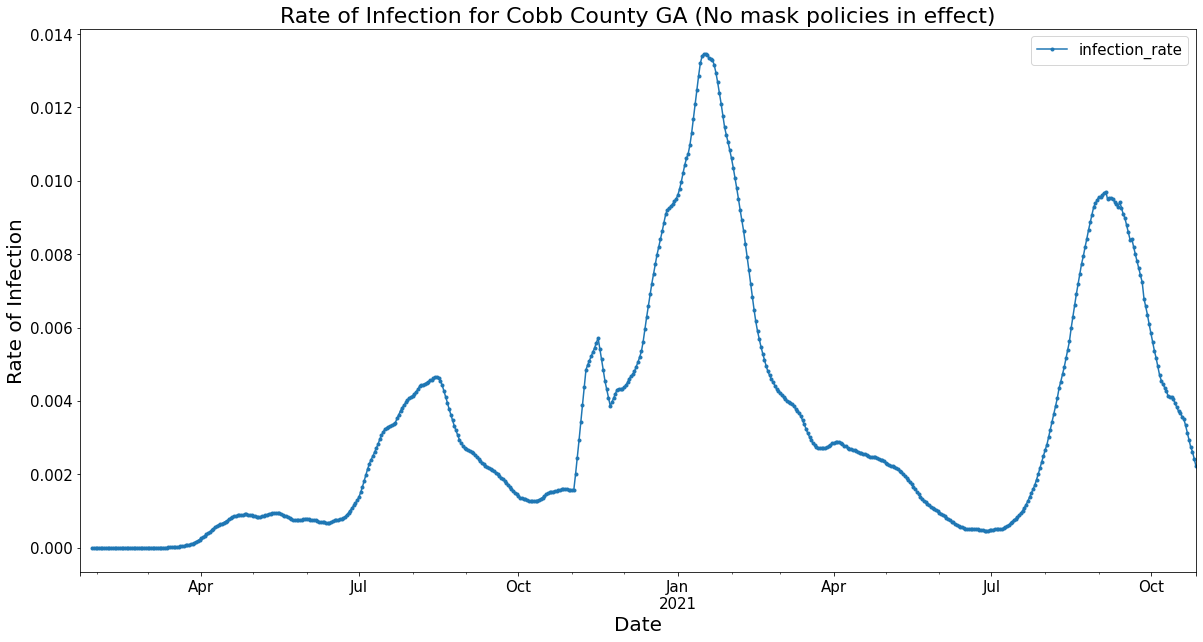

In [15]:
ax = mcc_cobb['infection_rate'].plot(marker='.', legend =True, figsize =(20,10), fontsize=15, x_compat=False)
ax.set_title('Rate of Infection for Cobb County GA (No mask policies in effect)',fontdict={'fontsize':22})
ax.set_xlabel('Date', fontsize=20)
ax.set_ylabel('Rate of Infection', fontsize=20)
ax.legend(loc=1,fontsize=15)


# Start of A7 analysis
* Package imports for A7 are in the import section at the top of the notebook.

# Read Domestic Crime Data
Domestic crime data is manually scraped from Atlanta Police Department's weekly release and is from 2018 to 2021
https://www.atlantapd.org/i-want-to/crime-data-downloads

In [16]:
dv = pd.read_csv('domestic_crime_data.csv')

## Investigative plots and tables to get a basic understanding of the data

In [17]:
dv.head()

,Week,weekly_21,weekly_20,weekly_19,weekly_18,ytd_21,ytd_20,ytd_19,ytd_18
0,1,15.0,14,7,12,15.0,14,7,12
1,2,15.0,13,9,8,30.0,27,16,20
2,3,12.0,7,12,9,44.0,34,28,29
3,4,8.0,7,7,15,47.0,41,35,44
4,5,14.0,13,2,7,64.0,54,37,51


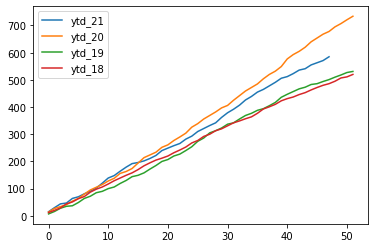

In [18]:
dv[['ytd_21', 'ytd_20', 'ytd_19', 'ytd_18']].plot()

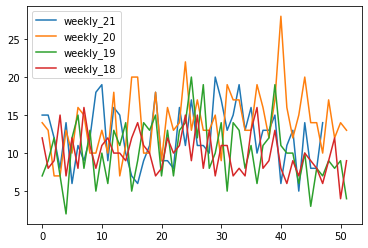

In [19]:
dv[['weekly_21', 'weekly_20', 'weekly_19', 'weekly_18']].plot()

In [20]:
dv.mean(skipna=True)

Week          26.500000
weekly_21     12.187500
weekly_20     14.115385
weekly_19     10.211538
weekly_18     10.000000
ytd_21       299.895833
ytd_20       355.634615
ytd_19       275.192308
ytd_18       277.000000
dtype: float64

# Data Cleaning and Feature Creation

## Calculate average run rate of 2021 and project rate of domestic violence (dv) through end of 2021.
This projected rate is used for a powerpoint presentation graph. I've embedded the graph in the notebook right below this text.

![Yearly Reported Domestic Violence Cases](images/yearly_reported_dv_cases.png)

In [21]:
# calculate average dv cases per week and multiply them by weeks left in 2021.
idx = dv['ytd_21'].last_valid_index()
ytd_cases = dv['ytd_21'].loc[idx]
rate = ytd_cases/dv['Week'].loc[idx]
weeksleft = 52 - dv['Week'].loc[idx]
projected_cases = round(rate*weeksleft)
print("projected cases left in 2021: " + str(projected_cases))
print ("Total 2021 cases + projected cases: " + str(projected_cases + ytd_cases))

projected cases left in 2021: 49.0
Total 2021 cases + projected cases: 634.0


## Create a dataframes that are continuous timeseries that can be used for plotting timeseries graphs

In [22]:
# Create timeseries for each year for easy manipulation
time21 = dv[['weekly_21']].copy()
time20 = dv[['weekly_20']].copy()
time19 = dv[['weekly_19']].copy()
time18 = dv[['weekly_18']].copy()

time21.rename(columns={"weekly_21": "weekly_cases"}, inplace=True)
time20.rename(columns={"weekly_20": "weekly_cases"}, inplace=True)
time19.rename(columns={"weekly_19": "weekly_cases"}, inplace=True)
time18.rename(columns={"weekly_18": "weekly_cases"}, inplace=True)

time21['year']=2021
time20['year']=2020
time19['year']=2019
time18['year']=2018

### Create time series for precovid times and postcovid times. Definined by the first case identified in Atlanta, GA

Date determined by Georgia Department of Public Health statement: https://dph.georgia.gov/press-releases/2020-03-02/gov-kemp-officials-confirm-two-cases-covid-19-georgia


In [23]:
# Create time series for precovid times and postcovid times. Definined by the first case identified in Atlanta, GA
precovid = pd.concat([time18, time19], ignore_index=True)
covid = pd.concat([time20, time21], ignore_index=True)

#Add a weekly datetime column to the precovid dataframe
start = datetime.datetime(2018, 1, 1)
dates = []
for i in range(len(precovid)):
    time = start + datetime.timedelta(weeks=i)
    dates.append(time)

precovid['date'] = dates

#Add a weekly datetime column to the covid dataframe
start = datetime.datetime(2020, 1, 1)
dates = []
for i in range(len(covid)):
    time = start + datetime.timedelta(weeks=i)
    dates.append(time)

covid['date'] = dates

# Actualy set accurate dates for the dataframes
early_2020 = covid.drop(covid[covid.date>=datetime.datetime(2020, 3, 2)].index)
covid.drop(covid[covid.date<datetime.datetime(2020, 3, 2)].index, inplace=True)
precovid =  pd.concat([precovid, early_2020], ignore_index=True)
precovid['pandemic_status'] = 'prepandemic'
covid['pandemic_status'] = 'pandemic'
# cleaning of covid df
covid.dropna(inplace=True)


In [24]:
min(covid.date)

Timestamp('2020-03-04 00:00:00')

### Create final combined timeseries with prepandemic and pandemic flags and a date column.

In [25]:
ts = pd.concat([precovid, covid], ignore_index=True)
ts.head()

,weekly_cases,year,date,pandemic_status
0,12.0,2018,2018-01-01,prepandemic
1,8.0,2018,2018-01-08,prepandemic
2,9.0,2018,2018-01-15,prepandemic
3,15.0,2018,2018-01-22,prepandemic
4,7.0,2018,2018-01-29,prepandemic


In [26]:
ts[ts.pandemic_status == 'pandemic']

,weekly_cases,year,date,pandemic_status
113,10.0,2020,2020-03-04,pandemic
114,13.0,2020,2020-03-11,pandemic
115,10.0,2020,2020-03-18,pandemic
116,18.0,2020,2020-03-25,pandemic
117,7.0,2020,2020-04-01,pandemic
...,...,...,...,...
199,5.0,2021,2021-10-27,pandemic
200,14.0,2021,2021-11-03,pandemic
201,8.0,2021,2021-11-10,pandemic
202,8.0,2021,2021-11-17,pandemic


### Define some important dates as variables. Dates found by announcements made by Atlanta Mayor and Georgia Governer

In [27]:
first_case = datetime.datetime(2020, 3, 2)
maskmandate = datetime.datetime(2020, 4, 3)
vaccine_over16= datetime.datetime(2021, 3,25)

### Create a vaccine status column for the covid dataset. 
Created after ts creation so ts doesn't contain an unnecessary column.

In [28]:
covid['vaccine'] = np.where(covid.date<vaccine_over16, 'pre-vaccine','post-vaccine')

# Begin Statistical Analysis

In [29]:
# high level summary info
print('precovid \n')
print('standard deviation')
print(precovid.std())
print('\n mean')
print(precovid.mean())
print('\n\n covid \n')
print('standard deviation')
print(covid.std())
print('\n mean')
print(covid.mean())

precovid 

standard deviation
weekly_cases                       3.406949
year                               0.631305
date            229 days 14:32:15.933576296
dtype: object

 mean
weekly_cases      10.230088
year            2018.619469
dtype: float64


 covid 

standard deviation
weekly_cases                       4.131773
year                               0.502011
date            184 days 21:26:52.494674234
dtype: object

 mean
weekly_cases      13.340659
year            2020.527473
dtype: float64


# Run a welch t-test to test if the number of weekly reported domestic violence cases pre-COVID-19 are meaningfully less than the number of reported domestic violence cases during the COVID-19 pandemic for Atlanta, GA. 

H0: Domestic violence cases during the COVID-19 pandemic are equal to or less than domestic violence cases before the COVID-19 pandemic.

H1: Domestic violence cases during the COVID-19 pandemic are greater than domestic violence cases before the COVID-19 pandemic

In [30]:
p_list =[]
for _ in range(50):
    p = stats.ttest_ind(covid.weekly_cases.sample(60).values, precovid.weekly_cases.sample(60).values, equal_var=False, alternative = 'greater').pvalue
    p_list.append(p)
print("max p: " + str(max(p_list)))
print("mean p: " + str(mean(p_list)))
print("number of p values >= .05: " + str(sum(map(lambda x : x >= 0.05, p_list))))

max p: 0.0015532296851984244
mean p: 0.0001576507392028799
number of p values >= .05: 0


### in my analysis I recieved entirely p values < .05 so I confidently reject the null hypothesis in support of the alternative H1. Domestic violence cases during the COVID-19 pandemic are greater than domestic violence cases before the COVID-19 pandemic

# Run a welch t-test to see if the reported number of weekly domestic violence cases during the pandemic but before the vaccine are greater than reported number of weekly DV cases after the vaccine was released for Atlanta, GA. 
H0: the weekly reported number of domestic violence cases after the COVID-19 vaccine are equal to or greater than the weekly reported number of domestic violence cases during the pandemic but before vaccine.

H1: The weekly reported number of domestic violence cases after the COVID-19 vaccine are less than the weekly reported number of domestic violence cases during the pandemic but before vaccine.

In [31]:
p_list =[]
for _ in range(50):
    p = stats.ttest_ind(covid[covid.vaccine == 'post-vaccine'].weekly_cases.sample(30).values, covid[covid.vaccine == 'pre-vaccine'].weekly_cases.sample(30).values,alternative = 'less', equal_var=False).pvalue
    p_list.append(p)
print("max p: " + str(max(p_list)))
print("mean p: " + str(mean(p_list)))
print("number of p values >= .05: " + str(sum(map(lambda x : x >= 0.05, p_list))))

max p: 0.19232359723828307
mean p: 0.035326635246467626
number of p values >= .05: 13


### In my analysis I recieved several p-values > .05 so I fail to reject the null hypothesis H0. I cannot say that the weekly reported number of domestic violence cases after the COVID-19 vaccine are less than the weekly reported number of domestic violence cases during the pandemic but before vaccine.

# Change Point Detection using Ruptures Library
## I use changepoint detection to help verify my t-test results and for further insight into the data.

In [32]:
points=np.array(ts['weekly_cases'])

### Plot the changepoints

(<Figure size 720x432 with 1 Axes>,
 [<matplotlib.axes._subplots.AxesSubplot at 0x18885f5e640>])

Text(0.5, 1.0, 'Change Point Detection: Window-Based Search Method')

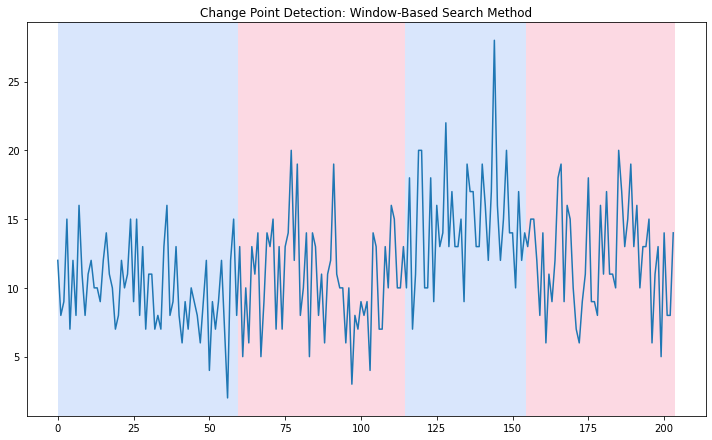

In [33]:
#Changepoint detection with window-based search method
model = "l2"  
algo = rpt.Window(width=40, model=model).fit(points)
my_bkps = algo.predict(n_bkps=10)
rpt.show.display(points, my_bkps, figsize=(10, 6))
plt.title('Change Point Detection: Window-Based Search Method')
plt.show()

### Print the dates of the changepoints

In [34]:
for i in my_bkps:
    print('change point: ')
    print(ts.iloc[i-1]['date'])
    print('\n')
    

change point: 
2019-02-18 00:00:00


change point: 
2020-03-11 00:00:00


change point: 
2020-12-16 00:00:00


change point: 
2021-11-24 00:00:00




### Brief interpretation of changepoints.

02/18/2019 cannot be explained by the data I have available to me.

03/11/2020 is the start of the pandemic and is 9 days after the first case reported in Atlanta 03/02/2020 and 12 days before the official lockdown 03/23/2020. This helps to confirm the welch t-test to test if the number of weekly reported domestic violence cases pre-COVID-19 are meaningfully less than the number of reported domestic violence cases during the COVID-19 pandemic for Atlanta, GA. 


12/16/2020 is during the height of the pandemic. COVID-19 cases were on the rise and would continue to rise until their peak in mid-late January 2021. This change point is not easily explained by the available data.

12/22/2021 is the last NULL point in the dataset and is not important.

The lack of change point for the vaccine availability is an indication that I was correct in not rejecting the null hypothesis H0: the weekly reported number of domestic violence cases during the pandemic but before the vaccine are equal to or less than the weekly reported number of domestic violence cases after the vaccine was available to the public.


# Plotting of domestic violence cases over time

### Normamalize method for layering COVID-19 cases onto plots of domestic violence data

In [35]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

### Calculate some constants for including mean and std bars on plots

In [36]:
mean_prevac = np.asarray([covid[covid.vaccine == 'pre-vaccine'].weekly_cases.mean()]*len(covid[covid.vaccine == 'pre-vaccine']))
std_prevac = np.asarray([covid[covid.vaccine == 'pre-vaccine'].weekly_cases.std()]*len(covid[covid.vaccine == 'pre-vaccine']))

mean_postvac = np.asarray([covid[covid.vaccine == 'post-vaccine'].weekly_cases.mean()]*len(covid[covid.vaccine == 'post-vaccine']))
std_postvac = np.asarray([covid[covid.vaccine == 'post-vaccine'].weekly_cases.std()]*len(covid[covid.vaccine == 'post-vaccine']))

## Plot Weekly reported DV cases during the pandemic

Text(0, 0.5, 'weekly reported DV cases')

Text(2020-03-23 00:00:00, 25, 'Atlanta lockdown')

Text(0, 0.5, 'weekly reported DV cases')

Text(2021-04-02 00:00:00, 25, 'COVID-19 vaccine available')

Text(2021-04-02 00:00:00, 23, 'to Georgians 16+')

Text(0, 0.5, 'weekly reported DV cases')

Text(0.5, 1.0, 'Weekly reported DV cases during the pandemic')

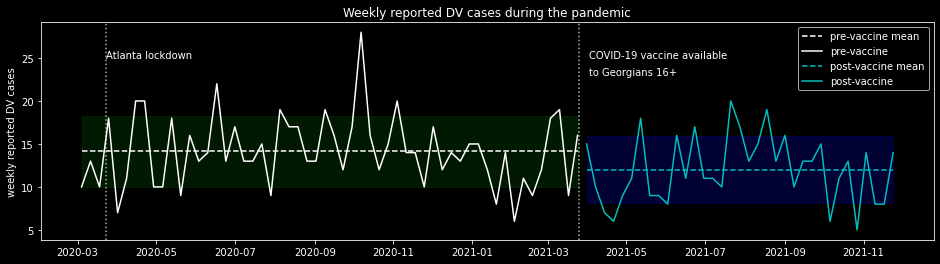

In [37]:
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (16,4)


_, ax = plt.subplots()
plt.plot(covid[covid.vaccine == 'pre-vaccine'].date, mean_prevac, label='mean cases', color='w',linestyle='--')    
plt.plot(covid[covid.vaccine == 'pre-vaccine'].date, covid[covid.vaccine == 'pre-vaccine'].weekly_cases, label='cases', color='w')    
plt.fill_between(covid[covid.vaccine == 'pre-vaccine'].date, mean_prevac - std_prevac, mean_prevac + std_prevac, color='g', alpha=0.2)
plt.plot(covid[covid.vaccine == 'post-vaccine'].date, mean_postvac, label='mean cases', color='c',linestyle='--') 
plt.plot(covid[covid.vaccine == 'post-vaccine'].date, covid[covid.vaccine == 'post-vaccine'].weekly_cases, label='cases', color='c')    
plt.fill_between(covid[covid.vaccine == 'post-vaccine'].date, mean_postvac - std_postvac, mean_postvac + std_postvac, color='b', alpha=0.2)
ax.set_ylabel('weekly reported DV cases')
plt.axvline(datetime.datetime(2020, 3,23), linestyle=':',alpha=0.7)
plt.text(datetime.datetime(2020, 3,23),25,'Atlanta lockdown',rotation=0)
ax.legend(['pre-vaccine mean', 'pre-vaccine','post-vaccine mean','post-vaccine'], loc='best')
ax.set_ylabel('weekly reported DV cases')
plt.axvline(datetime.datetime(2021, 3,25), linestyle=':',alpha=0.7)
plt.text(vaccine_over16+ datetime.timedelta(days=8),25,'COVID-19 vaccine available',rotation=0)
plt.text(vaccine_over16+ datetime.timedelta(days=8),23,'to Georgians 16+',rotation=0)
ax.set_ylabel('weekly reported DV cases')
ax.set_title("Weekly reported DV cases during the pandemic")

plt.savefig('images/pre_post_vaccine_domestic_violence_cases.png', transparent=True)

# Plot Weekly reported dv cases from 2018 to today colored by year

### Normalize active covid infections for layering on plot 

In [38]:
mcc_cobb['Active COVID Cases'] = NormalizeData(mcc_cobb['infected'])*30

### Plot

Text(0, 0.5, 'weekly reported dv cases')

Text(0.5, 0, 'date')

Text(2020-03-23 00:00:00, 29, 'Atlanta lockdown')

Text(2021-05-27 00:00:00, 22, 'Reopen (Phase 3)')

Text(2021-04-02 00:00:00, 29, 'COVID-19 vaccine available')

Text(2021-04-02 00:00:00, 27, 'to Georgians 16+')

Text(0.5, 1.0, 'Weekly reported dv cases from 2018 to today')

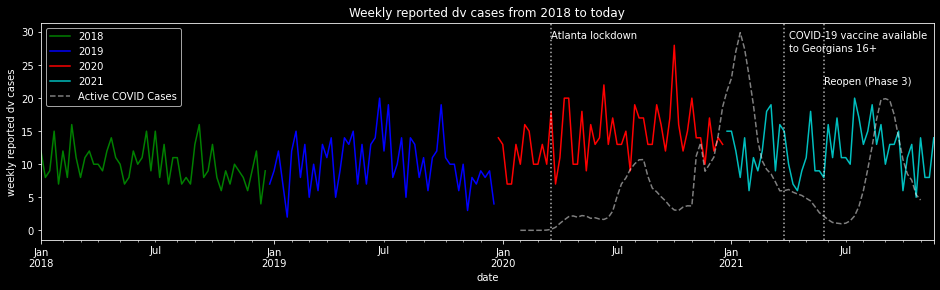

In [39]:
plt.rcParams["figure.figsize"] = (16,4)
plt.style.use('dark_background')

_, ax = plt.subplots()
colors = {2018:'g', 2019:'b',2020:'r', 2021:'c'}


for n, g in ts.groupby('year'):
     g.plot('date','weekly_cases', ax=ax, color=colors[n])

ax.legend(['2018', '2019', '2020', '2021'], loc='best')

ax.set_ylabel('weekly reported dv cases')
ax.set_xlabel('date')

mcc_cobb['Active COVID Cases'].plot(color='w',linestyle='dashed', legend=True, alpha=0.5)

# plt.axvline(first_case, linestyle=':',alpha=0.7)
# plt.text(first_case+ datetime.timedelta(days=5),29,'First Reported COVID-19',rotation=0)
# plt.text(first_case+ datetime.timedelta(days=5),27,'case in GA',rotation=0)


plt.axvline(datetime.datetime(2020, 3,23), linestyle=':',alpha=0.7)
plt.text(datetime.datetime(2020, 3,23),29,'Atlanta lockdown',rotation=0)


plt.axvline(datetime.datetime(2021, 5,27), linestyle=':',alpha=0.7)
plt.text(datetime.datetime(2021, 5, 27),22,'Reopen (Phase 3)',rotation=0)

plt.axvline(datetime.datetime(2021, 3,25), linestyle=':',alpha=0.7)
plt.text(vaccine_over16+ datetime.timedelta(days=8),29,'COVID-19 vaccine available',rotation=0)
plt.text(vaccine_over16+ datetime.timedelta(days=8),27,'to Georgians 16+',rotation=0)
ax.set_title("Weekly reported dv cases from 2018 to today")
# plt.savefig('dv_cases.png', transparent=True)

## Plot Weekly reported DV cases from 2018 to today colored by prepandemic and  pandemic status

Text(0, 0.5, 'weekly reported DV cases')

Text(0.5, 0, 'date')

Text(2020-03-23 00:00:00, 29, 'Atlanta lockdown')

Text(2021-05-27 00:00:00, 22, 'Reopen (Phase 3)')

Text(2021-04-02 00:00:00, 29, 'COVID-19 vaccine available')

Text(2021-04-02 00:00:00, 27, 'to Georgians 16+')

Text(0.5, 1.0, 'Weekly reported DV cases from 2018 to today')

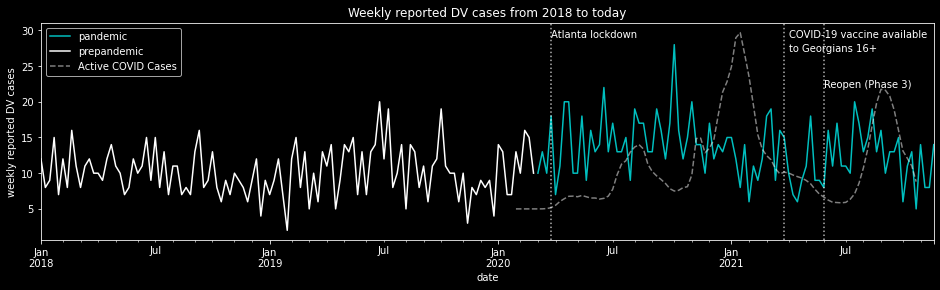

In [40]:
# Normalize active covid infections for layering on plot 
mcc_cobb['Active COVID Cases'] = NormalizeData(mcc_cobb['infected'])*25+5


plt.rcParams["figure.figsize"] = (16,4)
plt.style.use('dark_background')

_, ax = plt.subplots()
colors = {'prepandemic':'w', 'pandemic':'c'}


for n, g in ts.groupby('pandemic_status'):
     g.plot('date','weekly_cases', ax=ax, color=colors[n])

ax.legend(['pandemic', 'prepandemic'], loc='best')

ax.set_ylabel('weekly reported DV cases')
ax.set_xlabel('date')

mcc_cobb['Active COVID Cases'].plot(color='w',linestyle='dashed', legend=True, alpha=0.5)

# plt.axvline(first_case, linestyle=':',alpha=0.7)
# plt.text(first_case+ datetime.timedelta(days=5),29,'First Reported COVID-19',rotation=0)
# plt.text(first_case+ datetime.timedelta(days=5),27,'case in GA',rotation=0)


plt.axvline(datetime.datetime(2020, 3,23), linestyle=':',alpha=0.7)
plt.text(datetime.datetime(2020, 3,23),29,'Atlanta lockdown',rotation=0)


plt.axvline(datetime.datetime(2021, 5,27), linestyle=':',alpha=0.7)
plt.text(datetime.datetime(2021, 5, 27),22,'Reopen (Phase 3)',rotation=0)

plt.axvline(datetime.datetime(2021, 3,25), linestyle=':',alpha=0.7)
plt.text(vaccine_over16+ datetime.timedelta(days=8),29,'COVID-19 vaccine available',rotation=0)
plt.text(vaccine_over16+ datetime.timedelta(days=8),27,'to Georgians 16+',rotation=0)
ax.set_title("Weekly reported DV cases from 2018 to today")
plt.savefig('images/pre_post_pandemic_weekly_domestic_violence_cases.png', transparent=True)

## Create a dataframe of monthly domestic violence cases

In [41]:
# create a dataframe df with the correct number of days that exist in the data and with a populated date column
delta = max(covid.date) - min(covid.date)
rng = pd.date_range('2020-03-04', periods=delta.days+1, freq='D')
df = pd.DataFrame({ 'date': rng, 'Cases' :0}) 

#merge this df with covid data which will produce a sparely populated dataframe with one DV entry per week
dfc = pd.merge(df, covid, how="left", on=["date"])
# fill in each day with the same weekly dv count
dfc = dfc.fillna(method='bfill')
#get average daily dv cases by deviding the weekly number by 7
dfc['dailycases'] = dfc.weekly_cases/7
#format index
dfc.set_index('date', inplace=True)

dfc.head()

,Cases,weekly_cases,year,pandemic_status,vaccine,dailycases
date,,,,,,
2020-03-04,0,10.0,2020.0,pandemic,pre-vaccine,1.428571
2020-03-05,0,13.0,2020.0,pandemic,pre-vaccine,1.857143
2020-03-06,0,13.0,2020.0,pandemic,pre-vaccine,1.857143
2020-03-07,0,13.0,2020.0,pandemic,pre-vaccine,1.857143
2020-03-08,0,13.0,2020.0,pandemic,pre-vaccine,1.857143


### Get monthly cases by gouping by month and summing the dailycases

In [42]:
monthly = dfc.groupby(by=[dfc.index.month, dfc.index.year]).sum()

monthly

Cases  weekly_cases     year  dailycases
date date                                          
1    2021      0         352.0  62651.0   50.285714
2    2021      0         314.0  56588.0   44.857143
3    2020      0         339.0  56560.0   48.428571
     2021      0         467.0  62651.0   66.714286
4    2020      0         444.0  60600.0   63.428571
     2021      0         246.0  60630.0   35.142857
5    2020      0         413.0  62620.0   59.000000
     2021      0         347.0  62651.0   49.571429
6    2020      0         484.0  60600.0   69.142857
     2021      0         401.0  60630.0   57.285714
7    2020      0         405.0  62620.0   57.857143
     2021      0         445.0  62651.0   63.571429
8    2020      0         489.0  62620.0   69.857143
     2021      0         477.0  62651.0   68.142857
9    2020      0         474.0  60600.0   67.714286
     2021      0         379.0  60630.0   54.142857
10   2020      0         557.0  62620.0   79.571429
     2021      0         295.0  62651.0   42.142857
11   2020      0         431.0  60600.0   61.571429
     2021      0         252.0  48504.0   36.000000
12   2020      0         427.0  62628.0   61.000000

### finally create the monthly dataframe and populate the dates and the cases. The cases are manually pulled from the print out above. There is likely a better way to do this, however manual translation worked for this dataset.

In [43]:
monthly_df = pd.DataFrame()
start = datetime.datetime(2020, 3, 1)
dates = []
for i in range(len(monthly)):
    time = start + pd.DateOffset(months=i)
    dates.append(time)

monthly_df['date'] = dates

monthly_df['cases'] = [48,63, 59, 69, 58, 70, 68, 80, 62, 61, 50, 45, 67, 35, 46, 57, 64, 68, 54, 42, 36]

# Plot Monthly reported DV cases during the pandemic

Text(0.5, 0, 'date')

Text(2020-03-23 00:00:00, 75, 'Atlanta lockdown')

Text(2021-03-27 00:00:00, 80, 'COVID-19 vaccine')

Text(2021-03-27 00:00:00, 78, 'available to Georgians 16+')

Text(2021-05-27 00:00:00, 35, 'Reopen (Phase 3)')

Text(0.5, 1.0, 'Monthly reported DV cases during the pandemic')

Text(0, 0.5, 'monthly reported dv cases')

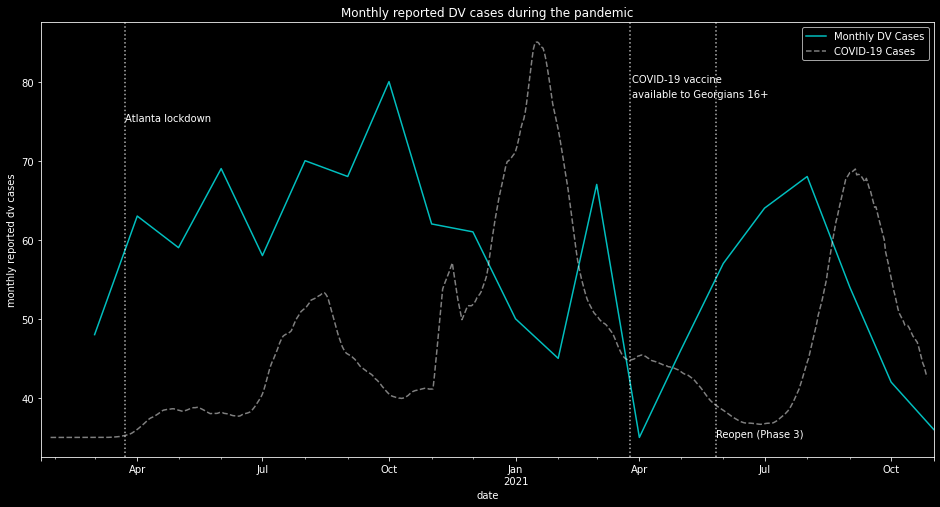

In [44]:
#normalize active covid cases relative to scale of DV cases
mcc_cobb['Active COVID Cases'] = NormalizeData(mcc_cobb['infected'])*50+35

#Plotting and formatting
plt.rcParams["figure.figsize"] = (16,8)
plt.style.use('dark_background')

_, ax = plt.subplots()

monthly_df.plot('date','cases', ax=ax, color='c')

ax.legend(['pandemic', 'prepandemic'], loc='best')



ax.set_xlabel('date')

mcc_cobb['Active COVID Cases'].plot(color='w',linestyle='dashed', legend=True, alpha=0.5)


plt.axvline(datetime.datetime(2020, 3,23), linestyle=':',alpha=0.7)
plt.text(datetime.datetime(2020, 3,23),75,'Atlanta lockdown',rotation=0)



plt.axvline(datetime.datetime(2021, 3,25), linestyle=':',alpha=0.7)
plt.text(vaccine_over16+ datetime.timedelta(days=2),80,'COVID-19 vaccine',rotation=0)
plt.text(vaccine_over16+ datetime.timedelta(days=2),78,'available to Georgians 16+',rotation=0)


plt.axvline(datetime.datetime(2021, 5,27), linestyle=':',alpha=0.7)
plt.text(datetime.datetime(2021, 5, 27),35,'Reopen (Phase 3)',rotation=0)



ax.set_title("Monthly reported DV cases during the pandemic")
ax.set_ylabel('monthly reported dv cases')
ax.legend(['Monthly DV Cases', 'COVID-19 Cases'], loc='best')

plt.savefig('images/monthly_domestic_violence_cases.png', transparent=True)